In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context('notebook', font_scale=1.3)

from jupyterthemes import jtplot
jtplot.reset()

In [16]:
def load(pol):
    df = pd.DataFrame(pd.read_pickle(f'data/strategy_frequencies_{pol}.pkl'))
    df = df.reset_index().rename(columns={'index': 'heuristic'})
    df = pd.melt(df, id_vars='heuristic')
    s, d = zip(*df.pop('variable').str.split('_'))
    df['sigma'] = pd.Series(s).apply({'hs': 'High', 'ls': 'Low'}.get)
    df['dispersion'] = pd.Series(d).apply({'hd': 'High', 'ld': 'Low'}.get)
    df['agent'] = pol if len(pol) < 3 else pol.title()
    return df

df = pd.concat(load(pol) for pol in ['DC', 'RR', 'human'])
df = df.query('heuristic != "TTB2"')
df.heuristic = df.heuristic.str.replace('_plus', '+')
df.heuristic = df.heuristic.str.replace('random_choice', 'Random')
df.heuristic = df.heuristic.str.replace('other', 'Other')
df.heuristic = df.heuristic.str.replace('_', '-')

In [17]:
totals = df.groupby(['agent', 'dispersion', 'sigma']).value.sum()
assert len(totals) == 3 * 2 * 2
assert (totals == 1).all()

In [18]:
pal = sns.color_palette()
pal[3] = '#999999'
pal = ['C0', 'C1', 'gray']
pal = dict(zip(['DC', 'RR', 'Human'], pal))


In [19]:
drop = df.groupby('heuristic').value.max() < 0.01
drop['Other'] = True
df = df.set_index('heuristic').loc[~drop].reset_index()

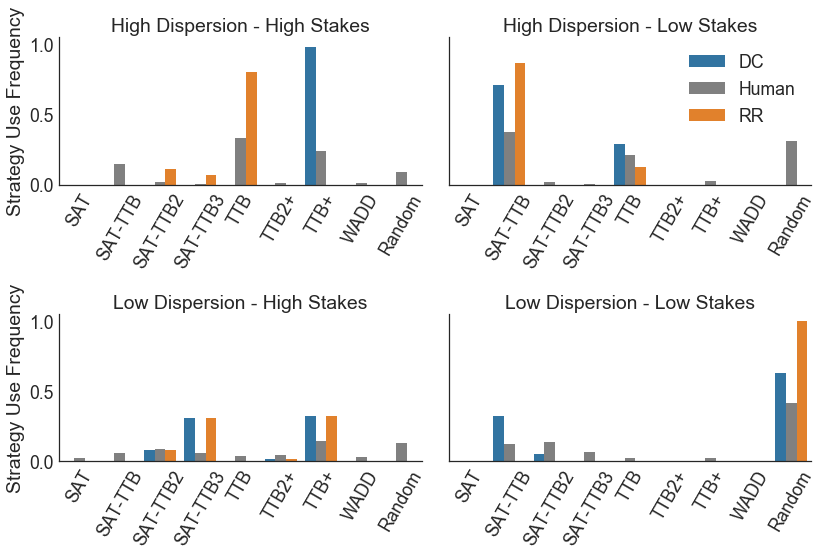

In [20]:
order = list(df.heuristic.unique())
try:
    order.remove('Other')
    order.append('Other')
except:
    pass

sns.set('paper', 'white', 'tab10', font_scale=2.2)
g = sns.factorplot('heuristic', 'value', hue='agent', col='sigma', row='dispersion', 
                   data=df,
                   kind='bar', aspect=1.5, order=order, sharex=False, palette=pal,
                   legend=False,
                   hue_order=['DC', 'Human', 'RR']
                  )
# g.set_xticklabels(rotation=60)
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=60)
g.set_titles('{row_name} Dispersion - {col_name} Stakes', )
g.axes[0, 1].legend(title='')
g.set_ylabels('Strategy Use Frequency')
g.set_xlabels('')
plt.tight_layout()